In [572]:
import math
from pathlib import Path
from typing import Sequence

import cv2
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from contourpy.array import offsets_from_codes

from numpy.ma.core import remainder

In [573]:
def load_frame_from_path(frame_path: str):
    img = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise Exception(f'frame not found at {frame_path}')
    as_array = jnp.asarray(img)
    assert as_array.ndim == 2
    normalized = as_array / 255.0
    return normalized


def nchw_img(img: jax.Array) -> jax.Array:
    assert img.ndim == 2
    return img[None, None, :, :]


In [574]:
f1 = nchw_img(load_frame_from_path(Path('./datasets/frames/toys/frame_000060.png')))
f2 = nchw_img(load_frame_from_path(Path('./datasets/frames/toys/frame_000063.png')))


In [575]:
def output_size(input_size: int, kernel_size: int, stride: int):
    """Calculate the output size of running a convolution over
    input size with a kernel_size and a given stride, without padding
    or dilation.
    """
    return int(math.floor((input_size - kernel_size) / stride)) + 1


def max_levels(input_size: int, kernel_size: int, stride: int, min_size: int):
    """Calculates the max amount of decomposition levels that would
    reduce the input size to no less than min_size.
    Returns a pair (max_level, output_size)
    returns -1 if input_size < min_size
    """
    levels = 0
    current_input = output = input_size
    while output >= min_size:
        current_input = output
        output = output_size(current_input, kernel_size, stride)
        levels += 1
    return levels - 1, current_input


output_size(256, 4, 2)
max_levels(256, 4, 2, 8)

(4, 14)

In [576]:

# todo: remove padding here, deal with loss of resolution later.
def decompose_image_nchw(img: jax.Array, levels: int = None, smallest_patch: int = 4) -> Sequence[
    jax.Array]:
    N, C, H, W = img.shape
    kernel_size = 4
    stride = 2
    pad = 2
    if levels is None:
        # incorrect, manually fixed but not considering kernel size and padding.
        levels, _ = max_levels(min(H, W), 2, stride, smallest_patch)
    kernel_side = jnp.array([0.5, 1, 1, 0.5])
    kernel = jnp.outer(kernel_side, kernel_side)
    norm_kernel = (kernel / jnp.sum(kernel))[None, None, :, :]
    pyramid = [img]
    current = img
    for level in range(levels):
        current = jnp.pad(current, ((0, 0), (0, 0), (1, 1), (1, 1)), mode='edge')
        current = jax.lax.conv_general_dilated(
            current,
            norm_kernel,
            window_strides=(stride, stride),
            padding='VALID'
        )
        pyramid.append(current)
    return pyramid


f1_pyramid = decompose_image_nchw(f1, smallest_patch=4)
f2_pyramid = decompose_image_nchw(f2, smallest_patch=4)
len(f1_pyramid), f1_pyramid[-1].shape


(7, (1, 1, 4, 4))

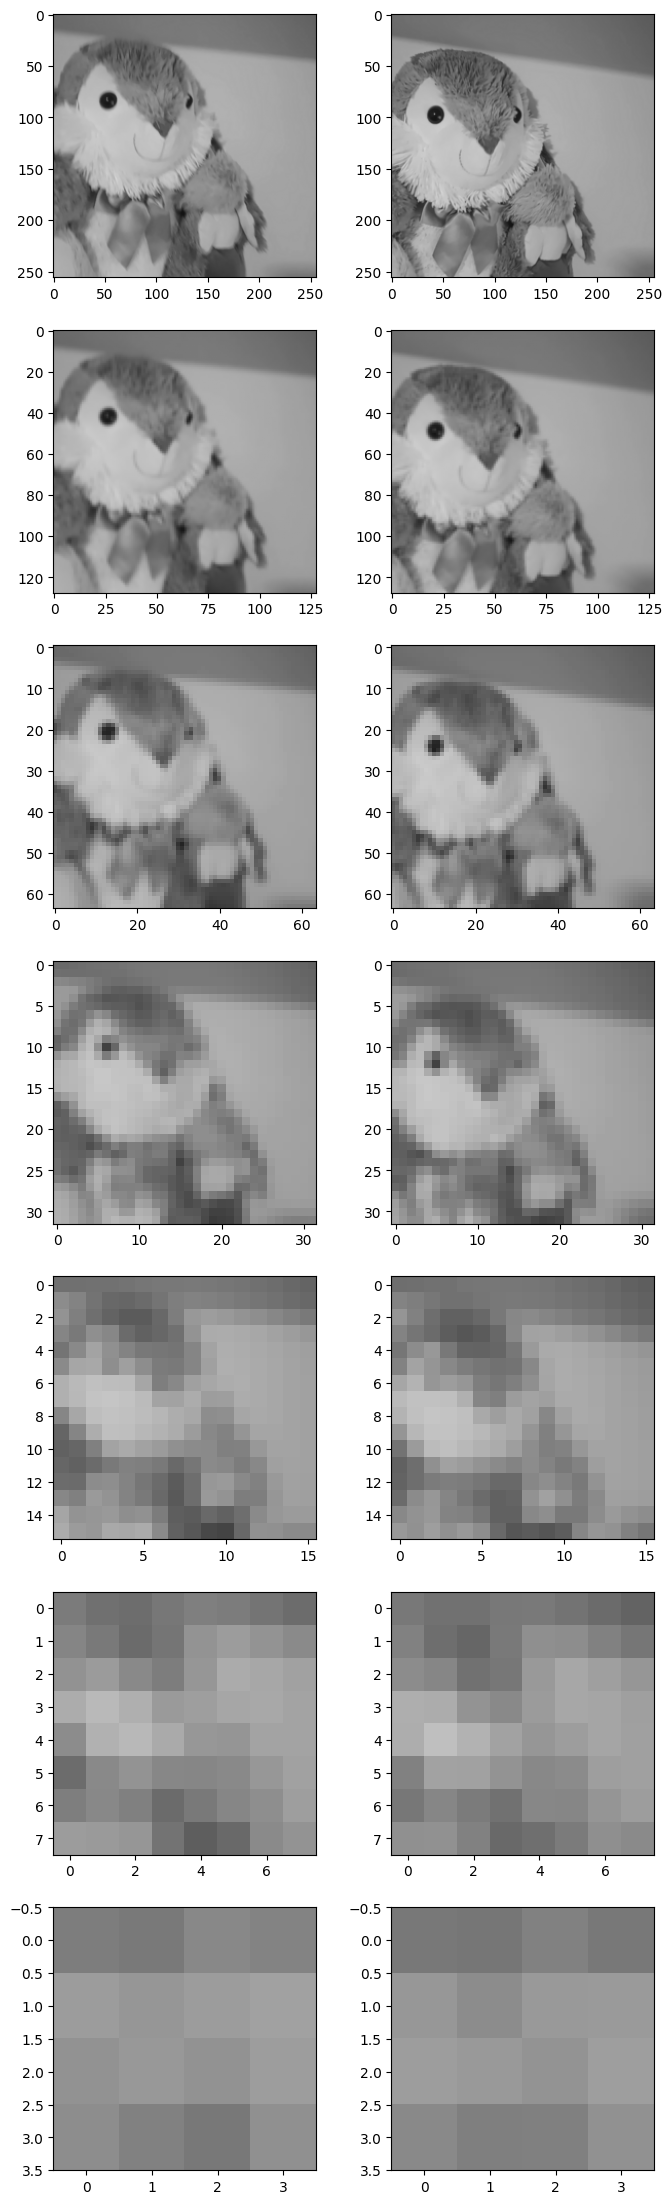

In [577]:
def display_pyramid_nchw(pyramid):
    fig, axes = plt.subplots(len(pyramid), 1, figsize=(4, 4 * len(pyramid)))
    for img, axe in zip(pyramid, axes):
        axe.imshow(img.squeeze((0, 1)), vmin=0, vmax=1, cmap='gray')
    plt.show()


def display_pyramids_side_by_side_nchw(pyramid1, pyramid2):
    assert len(pyramid1) == len(pyramid2)
    length = len(pyramid1)
    fig, axes = plt.subplots(length, 2, figsize=(8, 4 * length))
    for img1, img2, (ax1, ax2) in zip(pyramid1, pyramid2, axes):
        ax1.imshow(img1.squeeze((0, 1)), vmin=0, vmax=1, cmap='gray')
        ax2.imshow(img2.squeeze((0, 1)), vmin=0, vmax=1, cmap='gray')
    plt.show()


display_pyramids_side_by_side_nchw(f1_pyramid, f2_pyramid)
# print([p.shape for p in f1_pyramid])

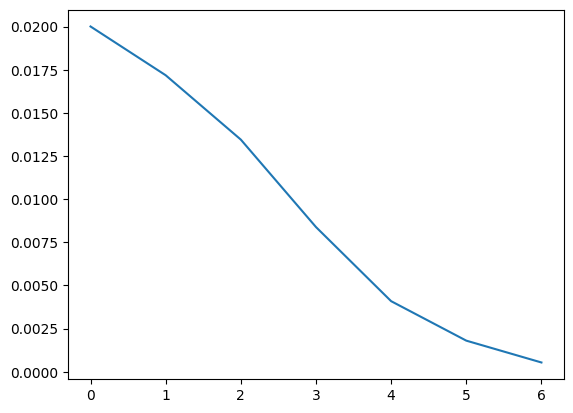

In [578]:
def patch_difference(patch1, patch2):
    H, W = patch1.shape
    assert patch1.shape == patch2.shape
    diff = ((patch1 - patch2) / (patch1 + patch2 + 1e-6)) ** 2
    return jnp.sum(diff) / ((H * W))


level_indexes = range(len(f1_pyramid))
ncc_per_level = [patch_difference(f1_pyramid[i][0, 0], f2_pyramid[i][0, 0]) for i in level_indexes]
plt.plot(level_indexes, ncc_per_level)


In [579]:
from scipy.ndimage import map_coordinates


@jax.jit
def shifted_2x2_over_3x3(input: jax.Array, flow: jax.Array) -> jax.Array:
    # flow is (dy, dx)
    # kernel should be ([(1-dx)*(1-dy), (dx*(1-dy)], [(1-dx)*dy, dx*dy]])
    neg_flow = 0.5 - flow
    pos_flow = 0.5 + flow
    flow_y = jnp.array([neg_flow[0], pos_flow[0]])
    flow_x = jnp.array([neg_flow[1], pos_flow[1]])
    kernel = jnp.outer(flow_y, flow_x)[None, None, :, :]
    center = jax.lax.conv(input[None, None, :, :], kernel, (1, 1), padding='valid')
    return center.squeeze((0, 1))


def patch_flow_loss(patch1: jax.Array, patch2: jax.Array, flow: jax.Array) -> jax.Array:
    # patch1, patch2 shape: 3,3
    # flow shape: 2,
    patch1_center = shifted_2x2_over_3x3(patch1, -flow / 2)
    patch2_shifted = shifted_2x2_over_3x3(patch2, flow / 2)
    return patch_difference(patch1_center, patch2_shifted)


def patch_flow_loss_grid(patches1: jax.Array, patches2: jax.Array, flow: (jax.Array)) -> (
        jax.Array):
    # patches1, patches2: [B, C=1, PY, PX, PH, PW]
    # patch_validity: [B, PY, PX] bool
    # flow: [B, 2, PY, PX]
    # return [B, 1, PY, PX]
    assert patches1.shape == patches2.shape
    B, C, PY, PX, PH, PW = patches1.shape
    FB, FC, FY, FX = flow.shape
    assert FB == B
    assert FC == 2
    assert FY == PY
    assert FX == PX
    assert C == 1
    flat_patches1 = patches1.reshape(B * C * PY * PX, PH, PW)
    flat_patches2 = patches2.reshape(B * C * PY * PX, PH, PW)
    flat_flow = flow.transpose(0, 2, 3, 1).reshape(B * PY * PX, FC)
    flat_losses = jax.vmap(patch_flow_loss)(flat_patches1, flat_patches2, flat_flow)
    return flat_losses.reshape(B, 1, PY, PX)


# patch_flow_loss_grid_with_grad = jax.jit(jax.value_and_grad(patch_flow_loss_grid, argnums=2))

patch_flow_loss_with_grad = jax.jit(jax.value_and_grad(patch_flow_loss, argnums=2))


@jax.jit
def estimate_flow_single_patch(patch1: jax.Array, patch2: jax.Array, prior: jax.Array) -> (
        jax.Array):
    # patch1, patch2: [PH, PW]
    # flow: [2,]
    for i in range(10):
        loss0, grad0 = patch_flow_loss_with_grad(
            patch1,
            patch2,
            prior,
        )
        prior -= jnp.clip(grad0 / (20 * loss0 + 1e-6), -0.05, 0.05)
    return prior


estimate_flow_patches = jax.vmap(estimate_flow_single_patch)
batched_estimate_flow_patches = jax.vmap(estimate_flow_patches)

base = jax.random.normal(jax.random.PRNGKey(42), shape=(4, 4)) * 0.2 + 0.5
patch1 = base[:3, :3]
patch2 = base[:3, 1:4]
patch_difference(patch1, patch2)
prior = jnp.zeros((2,))
print(patch_flow_loss(patch1, patch2, prior))
estimate_flow_single_patch(patch1, patch2, prior)


0.003887104


Array([ 0.00591, -0.5    ], dtype=float32)

In [580]:
def extract_patches_nchw(img: jax.Array, patch_size: int, stride: int) -> jax.Array:
    #img: (B, C, H, W)
    #returns: (B,C,PATCHES_Y,PATCHES_X, PH, PW)
    B, C, H, W = img.shape
    depth_patches = jax.lax.conv_general_dilated_patches(img, (patch_size, patch_size), (stride,
                                                                                         stride),
                                                         padding='VALID').transpose(0, 2, 3, 1)
    PH = output_size(H, patch_size, stride)
    PW = output_size(W, patch_size, stride)
    patches = depth_patches.reshape(B, PH, PW, C, patch_size, patch_size)
    return patches.transpose(0, 3, 1, 2, 4, 5)


def estimate_flow_batched_patches(patches1: jax.Array, patches2: jax.Array, prior: jax.Array) -> \
        tuple[jax.Array,
        jax
        .Array]:
    # patches1, patches2: (B, C, PY, PX, PH, PW)
    # prior: (B, 2, PY, PX)
    # returns (B,2,PY,PX)
    B, C, PY, PX, PH, PW = patches1.shape
    assert C == 1  # multi channel not implemented.
    assert patches1.shape == patches2.shape
    assert prior.shape == (B, 2, PY, PX)
    estimate_all_patches_flow = jax.vmap(estimate_flow_single_patch)
    flat_patches1 = patches1.reshape(B * PY * PX, PH, PW)
    flat_patches2 = patches2.reshape(B * PY * PX, PH, PW)
    flat_prior = prior.transpose(0, 2, 3, 1).reshape(B * PY * PX, 2)
    flat_flows = estimate_all_patches_flow(flat_patches1, flat_patches2, flat_prior)
    return flat_flows.reshape(B, PY, PX, 2).transpose(0, 3, 1, 2)


def estimate_lowest_pyramid_level():
    B, C, H, W = f1_pyramid[-1].shape
    assert C == 1
    # bug here. if we have multiple channels, we need to adjust how we
    # calculate multi-channel # losses.
    PY, PX = H - 2, W - 2  # assumes patch size=3, stride=1
    patches1 = extract_patches_nchw(f1_pyramid[-1], 3, 1)
    patches2 = extract_patches_nchw(f2_pyramid[-1], 3, 1)
    B, C, PY, PX, PH, PW = patches1.shape
    prior = jnp.zeros((B, 2, PY, PX)).astype(jnp.float32)
    initial_loss = patch_flow_loss_grid(patches1, patches2, prior)
    flow = estimate_flow_batched_patches(patches1, patches2, prior)
    final_loss = patch_flow_loss_grid(patches1, patches2, flow)
    return flow, initial_loss, final_loss


jnp.set_printoptions(precision=5, suppress=True, linewidth=120)
flow, initial, final = estimate_lowest_pyramid_level()
print(flow.shape)
print(initial.shape)
print(final.shape)
# base = jnp.arange(9).reshape(3,3)
# c11 = base * 1
# c12 = base * 2
# c21 = base * 3
# c22 = base * 4
# batched_multi_channel_example =  jnp.array([[c11, c12], [c21, c22]])
# patches = extract_patches_nchw(batched_multi_channel_example, 2, 1)
# print(batched_multi_channel_example.shape, patches.shape)
# print(batched_multi_channel_example[1,1])
# print(patches[1,1])

(1, 2, 2, 2)
(1, 1, 2, 2)
(1, 1, 2, 2)


In [581]:
losses = jnp.abs(jax.random.normal(jax.random.key(5), (3, 3)) * 1e-2)
threshold = 1e-2
weight_thresholds = (jnp.ones((3, 3)) * threshold / 2).at[1, 1].set(threshold)
weights = jnp.exp(-losses / weight_thresholds)
norm_weights = weights / weights.sum()
losses, norm_weights

(Array([[0.00084, 0.01411, 0.0063 ],
        [0.0131 , 0.01369, 0.00461],
        [0.02124, 0.01606, 0.00837]], dtype=float32),
 Array([[0.39213, 0.02761, 0.13155],
        [0.03379, 0.11809, 0.1845 ],
        [0.00664, 0.0187 , 0.08699]], dtype=float32))

In [582]:
def loss_to_weights(loss_patch: jax.Array):
    # return jax.nn.softmax(-loss_patch, axis=(0, 1))
    threshold = 1e-2
    weight_thresholds = (jnp.ones((3, 3)) * threshold / 2).at[1, 1].set(threshold)
    weights = jnp.exp(-loss_patch / weight_thresholds)
    norm_weights = weights / weights.sum()
    return norm_weights


def adjust_loss_single_patch(flow_patch: jax.Array, loss_patch: jax.Array):
    weights = loss_to_weights(loss_patch)
    return jnp.sum(flow_patch * weights, axis=(1, 2))


def adjust_flow_with_loss_patch(flow_with_loss: jax.Array):
    return adjust_loss_single_patch(flow_with_loss[0:2, :, :], flow_with_loss[2, :, :])


def flow_loss_correction(flow: jax.Array, loss: jax.Array) -> jax.Array:
    # flow: [B, 2, H, W]
    # loss: [B, 1, H, W]
    B, FC, H, W = flow.shape
    assert FC == 2
    flow_and_loss = jnp.concatenate([flow, loss], axis=1)
    padded = jnp.pad(flow_and_loss, ((0, 0), (0, 0), (1, 1), (1, 1)), mode='edge')
    patches = extract_patches_nchw(padded, 3, 1)  # B, C=3, H, W, 3, 3
    flat_patches = patches.transpose(0, 2, 3, 1, 4, 5).reshape(B * H * W, 3, 3, 3)
    flat_adjusted_flow = jax.vmap(adjust_flow_with_loss_patch)(flat_patches)  # B*H*W, 2
    adjusted_flow = flat_adjusted_flow.reshape(B, H, W, 2)
    return adjusted_flow.transpose(0, 3, 1, 2)


print(flow)
print(final)
flow_loss_correction(flow, final)

[[[[0.2     0.2    ]
   [0.1     0.1    ]]

  [[0.07013 0.1    ]
   [0.1     0.04241]]]]
[[[[0.00002 0.00004]
   [0.00002 0.00004]]]]


Array([[[[0.16668, 0.16668],
         [0.13333, 0.13332]],

        [[0.08032, 0.08057],
         [0.08059, 0.07109]]]], dtype=float32)

In [583]:
def upscale_flow(flow: jax.Array) -> jax.Array:
    B, F, H, W = flow.shape
    assert F == 2
    upscaled_flow = 2 * flow
    extended_upscaled_flow = upscaled_flow.repeat(2, axis=2).repeat(2, axis=3)
    padded_extended_upscaled_flow = jnp.pad(extended_upscaled_flow,
                                            ((0, 0), (0, 0), (1, 1), (1, 1)), mode='edge')
    return padded_extended_upscaled_flow


flow, _, _ = estimate_lowest_pyramid_level()
print(flow.shape)
upscaled = upscale_flow(flow)
print(upscaled.shape)


(1, 2, 2, 2)
(1, 2, 6, 6)


In [584]:
FH = FW = 4
grid_pair = jnp.meshgrid(jnp.arange(FH), jnp.arange(FW), indexing='ij')
grid = jnp.stack(grid_pair, axis=0).reshape(2, -1)
print(grid)
jnp.all(grid < jnp.array([3, 2]).reshape(2, 1), axis=0)

[[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]
 [0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3]]


Array([ True,  True, False, False,  True,  True, False, False,  True,  True, False, False, False, False, False, False],      dtype=bool)

In [585]:
def extract_single_shifted_patch(img: jax.Array, offset: jax.Array, patch_size: int):
    """
    img: C, H, W
    start_yx: 2,
    patch_size: ()
    returns: C, patch_size, patch_size
    """
    C, H, W = img.shape
    assert offset.shape == (2,)
    return jax.lax.dynamic_slice(
        img,
        (0, offset[0], offset[1]),
        (C, patch_size, patch_size),
        allow_negative_indices=False
    )


def extract_shifted_patches_nchw(single_frame, frame_int_flow, patch_size: int):
    """
    single_frame: C, H, W
    frame_int_flow: 2, H-patch_size+1, W-patch_size+1
    assumes stride=1
    returns (
        C * (H-patch_size+1) * (W-patch_size+1), patch_size, patch_size,
        C * (H-patch_size+1) * (W-patch_size+1), 1 (bool)
    """
    C, H, W = single_frame.shape
    F, FH, FW = frame_int_flow.shape
    assert F == 2
    assert FH == H - 2
    assert FW == W - 2
    grid_pair = jnp.meshgrid(jnp.arange(FH), jnp.arange(FW), indexing='ij')
    grid = jnp.stack(grid_pair, axis=0)
    offsets_grid = grid + frame_int_flow
    offsets_grid_flat = offsets_grid.reshape(2, -1)
    valid_coords_flat = get_valid_offsets_grid(H, W, offsets_grid_flat, patch_size)
    extract_all_patches = jax.vmap(extract_single_shifted_patch, in_axes=(None, 1, None))
    patches = extract_all_patches(single_frame, offsets_grid_flat, patch_size)
    return patches.reshape(C, FH, FW, patch_size, patch_size), valid_coords_flat.reshape(FH, FW)


def get_valid_offsets_grid(H, W, offsets_grid_flat, patch_size):
    valid_y_min = offsets_grid_flat[0, :] >= 0
    valid_x_min = offsets_grid_flat[1, :] >= 0
    valid_y_max = (offsets_grid_flat[0, :] + patch_size) <= H
    valid_x_max = (offsets_grid_flat[1, :] + patch_size) <= W
    valid_coords_flat = jnp.logical_and(
        jnp.logical_and(valid_y_min, valid_x_min),
        jnp.logical_and(valid_y_max, valid_x_max)
    )
    return valid_coords_flat


batch_extract_shifted_patches_nchw = jax.vmap(extract_shifted_patches_nchw, in_axes=(0, 0, None))

# test by picking the opposite corner patches
base = grid = jnp.arange(16).reshape(4, 4)
flow = jnp.array([[[1, 1], [-1, -1]], [[1, -1], [1, -1]]])
# flow = jnp.array([[[1, 1], [1, -1]], [[-1, 1], [-1, -1]]])
patches, valid = extract_shifted_patches_nchw(grid[None, ...], flow, 3)
print(base)
print(patches)
print(valid)




[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
[[[[[ 5  6  7]
    [ 9 10 11]
    [13 14 15]]

   [[ 4  5  6]
    [ 8  9 10]
    [12 13 14]]]


  [[[ 1  2  3]
    [ 5  6  7]
    [ 9 10 11]]

   [[ 0  1  2]
    [ 4  5  6]
    [ 8  9 10]]]]]
[[ True  True]
 [ True  True]]


In [586]:
def estimate_flow_patches_grid(patches1, patches2, priors):
    assert patches1.shape == patches2.shape
    B, C, PY, PX, PH, PW = patches1.shape
    assert priors.shape == (B, 2, PY, PX)
    flat_patches1 = patches1.reshape(B * C * PY * PX, PH, PW)
    flat_patches2 = patches2.reshape(B * C * PY * PX, PH, PW)
    flat_priors = priors.transpose(0, 2, 3, 1).reshape(B * PY * PX, 2)
    flat_flow = estimate_flow_patches(flat_patches1, flat_patches2, flat_priors)
    return flat_flow.reshape(B, PY, PX, 2).transpose(0, 3, 1, 2)


def estimate_flow_single_level(img1: jax.Array, img2: jax.Array, prior: jax.Array) -> jax.Array:
    # shape of img1, img2: (B, C, H, W)
    # shape of prior: (B, 2, H, W)
    patches1 = extract_patches_nchw(img1, 3, 1)
    B, C, W, H, PH, PW = patches1.shape
    int_priors = jnp.round(prior).astype(jnp.int32)
    remainder_priors = prior - int_priors
    patches2, patch_validity = batch_extract_shifted_patches_nchw(img2, int_priors, 3)
    level_flow = estimate_flow_patches_grid(patches1, patches2, remainder_priors)
    # level_loss = patch_flow_loss_grid(patches1, patches2, level_flow)
    return jax.lax.select(
        patch_validity.repeat(2, axis=0)[None, :, :, :],
        level_flow + int_priors,
        jnp.zeros((B, 2, W, H))
    )
    # corrected_level_flow = flow_loss_correction(level_flow, level_loss)
    # return corrected_level_flow + int_priors


flow0, _, _ = estimate_lowest_pyramid_level()
# print(flow0.shape)
upscaled_flow = upscale_flow(flow0)
# print(upscaled_flow.shape)
# print(upscaled_flow.shape)
# jnp.round(upscaled_flow)
flow1 = estimate_flow_single_level(f1_pyramid[-2], f2_pyramid[-2], upscaled_flow)
flow1.shape

(1, 2, 6, 6)

/tmp/ipykernel_1669603/1522477541.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


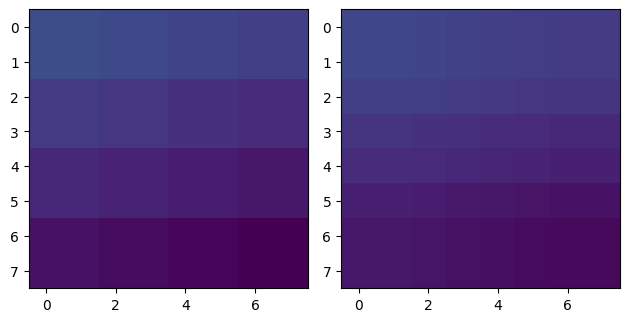

In [587]:
def smooth(prior: jax.Array) -> jax.Array:
    B, F, H, W = prior.shape
    assert F == 2
    batched_flow = prior.reshape(B * F, 1, H, W)
    kernel = jnp.array([[0.7, 0.8, 0.7], [0.8, 1, 0.8], [0.7, 0.8, 0.7]]).reshape((1, 1, 3, 3))
    # kernel = jnp.outer(kernel_base, kernel_base).reshape((1, 1, 3, 3))
    # kernel = jnp.ones((1, 1, 3, 3), dtype=jnp.float32)
    kernel = kernel / jnp.sum(kernel)
    smooth_batched_flow = jax.lax.conv_general_dilated(
        batched_flow, kernel, (1, 1), padding='valid'
    )
    # padding after smoothing to minimize error propagation from edges.
    padded_flow = jnp.pad(smooth_batched_flow, ((0, 0), (0, 0), (1, 1), (1, 1)), mode='edge')
    return padded_flow.reshape(B, F, H, W)


rough_flow_x = jnp.arange(16).reshape(4, 4).repeat(2, axis=0).repeat(2, axis=1)
rough_flow_y = jnp.arange(15, -1, -1).reshape(4, 4).repeat(2, axis=0).repeat(2, axis=1)
flows = jnp.stack([rough_flow_y, rough_flow_x], axis=0).astype(jnp.float32).reshape(1, 2, 8, 8)
# # # print(priors)
smooth_flows = smooth(flows)
# print(flows.shape, smooth_flows.shape)
# print(flows)
# print(smooth_flows)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(flows[0, 0, :, :], vmin=0, vmax=63)
ax2.imshow(smooth_flows[0, 0, :, :], vmin=0, vmax=63)
fig.tight_layout()
fig.show()

In [588]:

@jax.jit
def estimate_flow_multiple_levels(pyramid1: jax.Array, pyramid2: jax.Array,
                                  prior: jax.Array) -> jax.Array:
    B, C, H, W = pyramid1[-1].shape
    assert prior.shape == (B, H - 2, W - 2, 2)
    flows = []
    for img1, img2 in zip(reversed(pyramid1), reversed(pyramid2)):
        flow = estimate_flow_single_level(img1, img2, prior)
        flows.append(flow)
        upscaled_prior = upscale_flow(flow)
        prior = smooth(upscaled_prior)
    return flows[::-1]


In [589]:
def apply_flow_entire_image(img: jax.Array, flow: jax.Array) -> jax.Array:
    flow_y, flow_x = flow[0]
    H, W = flow_y.shape
    grid_y, grid_x = jnp.meshgrid(jnp.arange(H), jnp.arange(W), indexing='ij')
    return jax.scipy.ndimage.map_coordinates(img[0, 0], [grid_y + flow_y, grid_x + flow_x], order=1)

/tmp/ipykernel_1669603/3137553341.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


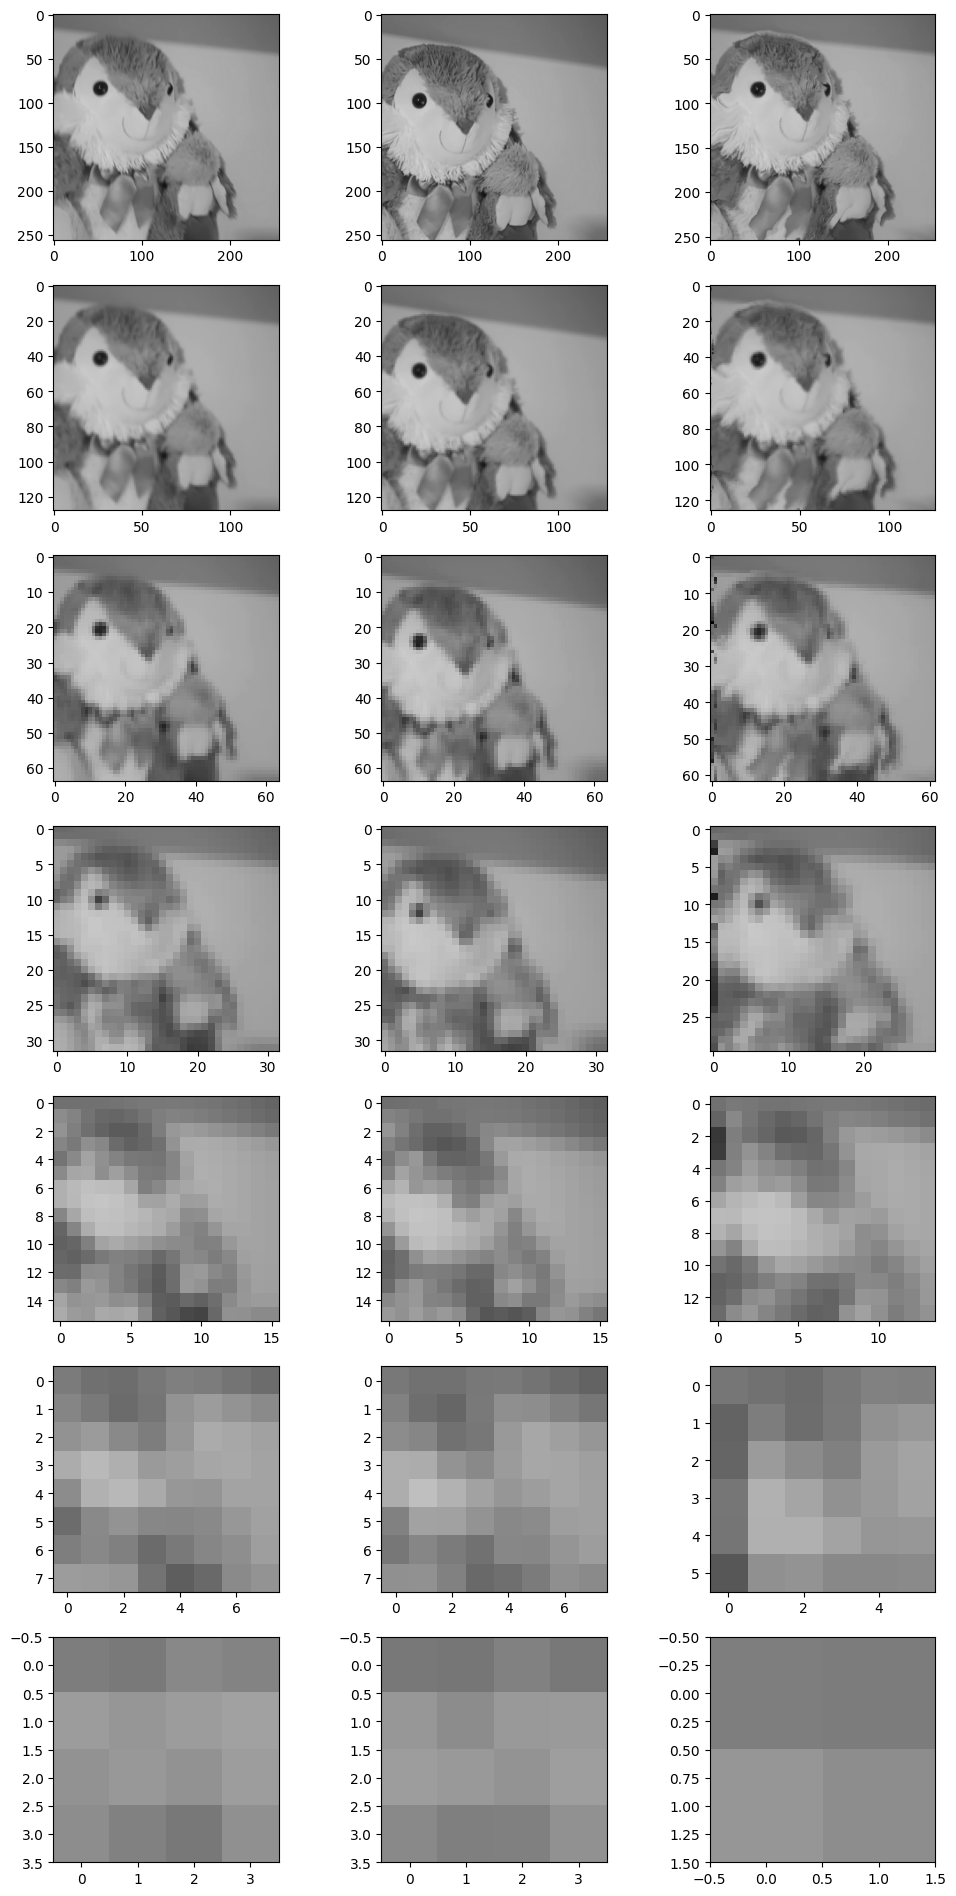

In [590]:
prior = jnp.zeros((1, 2, 2, 2))
flows = estimate_flow_multiple_levels(f1_pyramid, f2_pyramid, prior)
# [f.shape for f in flows]

fig, axs = plt.subplots(len(flows), 3, figsize=(12, 24))
for img1, img2, flow, ax in zip(f1_pyramid, f2_pyramid, flows, axs):
    ax[0].imshow(img1[0, 0], cmap='gray', vmin=0, vmax=1)
    ax[1].imshow(img2[0, 0], cmap='gray', vmin=0, vmax=1)
    flowed_img2 = apply_flow_entire_image(img2, flow)
    ax[2].imshow(flowed_img2, cmap='gray', vmin=0, vmax=1)
    # ax[2].imshow(flow[0, :, :, 0], cmap='viridis')
    # ax[3].imshow(flow[0, :, :, 1], cmap='viridis')
    # ax[4].imshow(jnp.linalg.norm(flow, ord=2, axis=-1)[0,:,:], cmap='viridis')

fig.show()


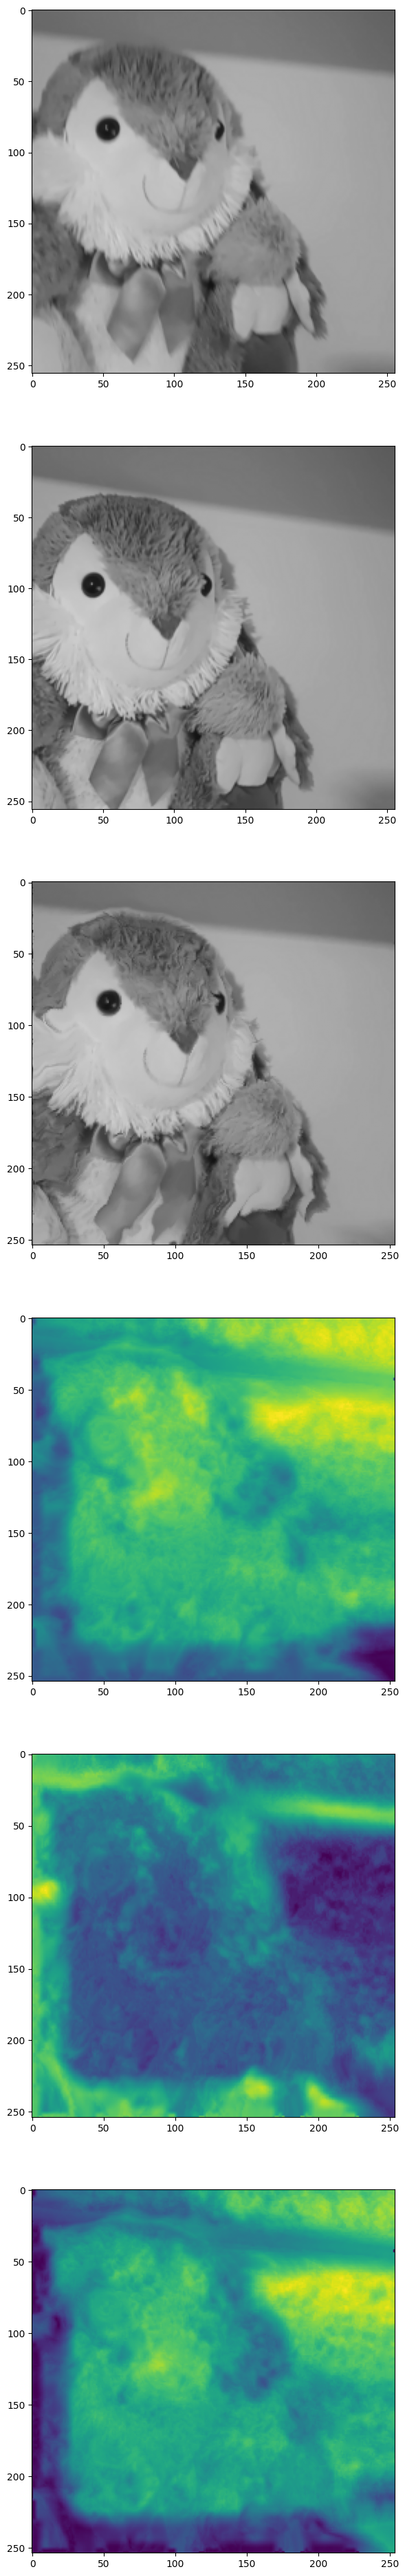

In [591]:
flow_fine_grained = flows[0]
f2_fine_grained = f2_pyramid[0]
flowed_large = apply_flow_entire_image(f2_fine_grained, flow_fine_grained)
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(12, 48))
ax1.imshow(f1_pyramid[0][0, 0], cmap='gray', vmin=0, vmax=1)
ax2.imshow(f2_pyramid[0][1, 0], cmap='gray', vmin=0, vmax=1)
ax3.imshow(flowed_large, cmap='gray', vmin=0, vmax=1)
ax4.imshow(flow_fine_grained[0, 0], cmap='viridis')
ax5.imshow(flow_fine_grained[0, 1], cmap='viridis')
pos = ax6.imshow(jnp.linalg.norm(flow_fine_grained[0], axis=0), cmap='viridis')
plt.show()